# 1. Import needed libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU, Embedding, BatchNormalization, Concatenate, Conv1D, GlobalMaxPooling1D, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os
from google.colab import files, drive


# 2. Read and Preprocess data

## 2.1 Read data

In [ ]:
# Install Kaggle
!pip install kaggle

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_kaggle_path = "/content/drive/MyDrive/Colab Notebooks/kaggle.json"
kaggle_dir = "/root/.kaggle/"

# Check for kaggle.json
if os.path.exists(drive_kaggle_path):
    print(f"Found kaggle.json in {drive_kaggle_path}")
    !mkdir -p {kaggle_dir}
    !cp "{drive_kaggle_path}" {kaggle_dir}
    !chmod 600 {kaggle_dir}/kaggle.json
else:
    print("kaggle.json not found in Google Drive. Please upload it.")
    uploaded = files.upload()
    if 'kaggle.json' not in uploaded:
        raise FileNotFoundError("You did not upload kaggle.json.")
    !mkdir -p {kaggle_dir}
    !mv kaggle.json {kaggle_dir}
    !chmod 600 {kaggle_dir}/kaggle.json

# Verify kaggle.json
if not os.path.exists(f"{kaggle_dir}/kaggle.json"):
    raise FileNotFoundError(f"Failed to set up kaggle.json in {kaggle_dir}")

# Download and unzip dataset
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp
!unzip -o emotions-dataset-for-nlp.zip -d emotions_dataset

# Load data
train_path = "/content/emotions_dataset/train.txt"
val_path = "/content/emotions_dataset/val.txt"
test_path = "/content/emotions_dataset/test.txt"

try:
    df = pd.read_csv(train_path, delimiter=';', header=None, names=['sentence', 'label'])
    val_df = pd.read_csv(val_path, delimiter=';', header=None, names=['sentence', 'label'])
    ts_df = pd.read_csv(test_path, delimiter=';', header=None, names=['sentence', 'label'])
    print("\nTrain DataFrame:\n", df.head())
    print("\nValidation DataFrame:\n", val_df.head())
    print("\nTest DataFrame:\n", ts_df.head())
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Check dataset files in /content/emotions_dataset/.")
    !ls /content/emotions_dataset/
    raise

# Visualize original label distributions
for dataset, title in [(df, 'Train'), (val_df, 'Validation'), (ts_df, 'Test')]:
    label_counts = dataset['label'].value_counts()
    light_colors = sns.husl_palette(n_colors=len(label_counts))
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
    plt.title(f'Emotion {title} Distribution')
    plt.show()


## 2.2 Balance dataset

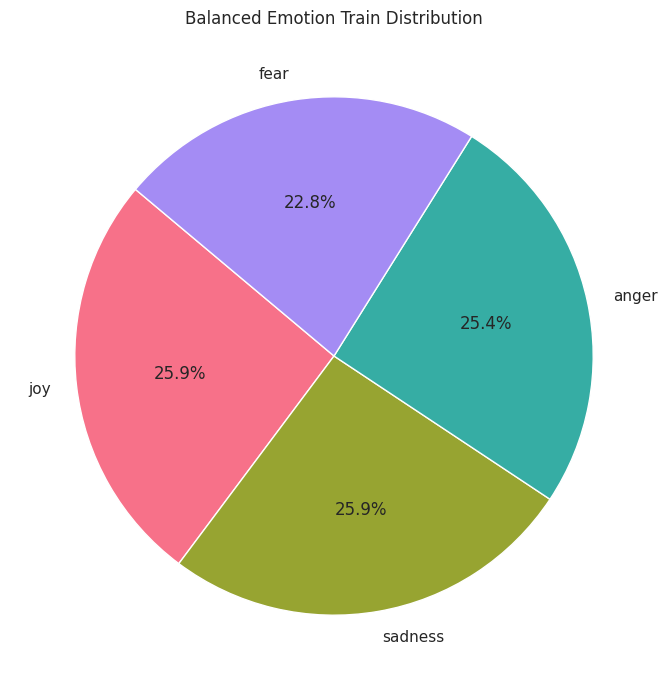

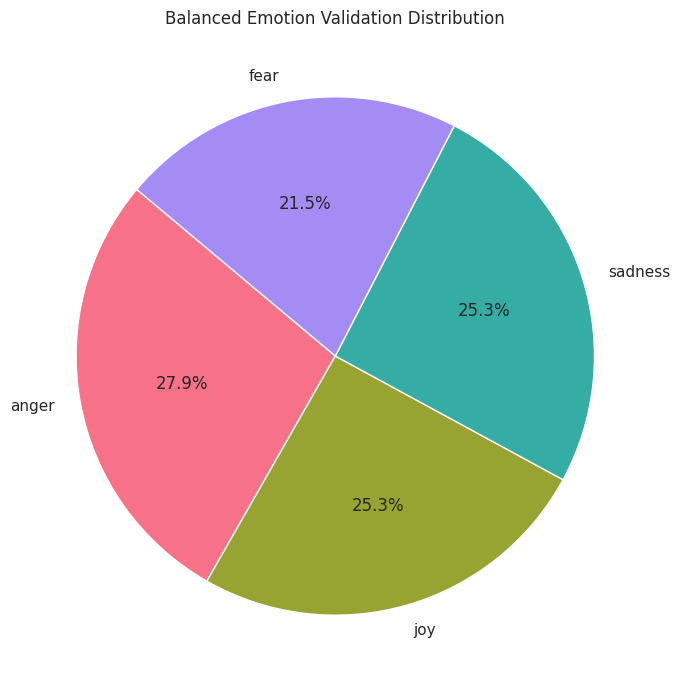

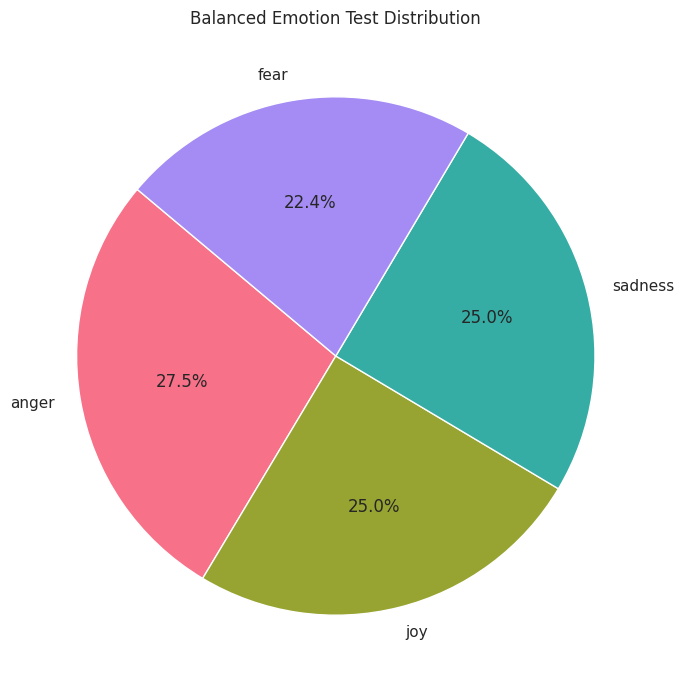

In [39]:
# Remove 'love' and 'surprise' and sample to balance classes
def balance_df(dataframe, random_state=20):
    df_filtered = dataframe[~dataframe['label'].str.contains('love|surprise', case=False)]
    joy = df_filtered[df_filtered['label'] == 'joy'].sample(n=2200 if dataframe is df else 250, random_state=random_state)
    sad = df_filtered[df_filtered['label'] == 'sadness'].sample(n=2200 if dataframe is df else 250, random_state=random_state)
    fear = df_filtered[df_filtered['label'] == 'fear'].sample(n=1937 if dataframe is df else 212 if dataframe is val_df else 224, random_state=random_state)
    anger = df_filtered[df_filtered['label'] == 'anger'].sample(n=2159 if dataframe is df else 275, random_state=random_state)
    df_sampled = pd.concat([joy, sad, fear, anger]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_sampled

df = balance_df(df)
val_df = balance_df(val_df)
ts_df = balance_df(ts_df)

# Verify balanced distributions
for dataset, title in [(df, 'Train'), (val_df, 'Validation'), (ts_df, 'Test')]:
    label_counts = dataset['label'].value_counts()
    light_colors = sns.husl_palette(n_colors=len(label_counts))
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
    plt.title(f'Balanced Emotion {title} Distribution')
    plt.show()

## 2.3 Split data into X, y

In [40]:
tr_text = df['sentence']
tr_label = df['label']
val_text = val_df['sentence']
val_label = val_df['label']
ts_text = ts_df['sentence']
ts_label = ts_df['label']

## 2.4 Encoding

In [41]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

# Convert to one-hot encoded labels
tr_y = to_categorical(tr_label)
val_y = to_categorical(val_label)
ts_y = to_categorical(ts_label)

## 2.5 Text preprocessing

In [42]:
max_words = 5000
max_len = 50
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(tr_text)

# Convert texts to sequences and pad
tr_sequences = tokenizer.texts_to_sequences(tr_text)
val_sequences = tokenizer.texts_to_sequences(val_text)
ts_sequences = tokenizer.texts_to_sequences(ts_text)

tr_x = pad_sequences(tr_sequences, maxlen=max_len, padding='post')
val_x = pad_sequences(val_sequences, maxlen=max_len, padding='post')
ts_x = pad_sequences(ts_sequences, maxlen=max_len, padding='post')

# Verify shapes
print("tr_x shape:", tr_x.shape)  # Should be (8496, 50)
print("tr_y shape:", tr_y.shape)  # Should be (8496, 4)
print("val_x shape:", val_x.shape)  # Should be (987, 50)
print("val_y shape:", val_y.shape)  # Should be (987, 4)
print("ts_x shape:", ts_x.shape)   # Should be (999, 50)
print("ts_y shape:", ts_y.shape)   # Should be (999, 4)
print("Max index in tr_x:", np.max(tr_x))  # Should be < 5000
print("Max index in val_x:", np.max(val_x))
print("Max index in ts_x:", np.max(ts_x))

tr_x shape: (8496, 50)
tr_y shape: (8496, 4)
val_x shape: (987, 50)
val_y shape: (987, 4)
ts_x shape: (999, 50)
ts_y shape: (999, 4)
Max index in tr_x: 4999
Max index in val_x: 4996
Max index in ts_x: 4975


# 3. Building deep learning model

## 3.1 Model architecture

In [51]:
input1 = Input(shape=(max_len,), name='input_1')
input2 = Input(shape=(max_len,), name='input_2')

# Branch 1
x1 = Embedding(max_words, embedding_dim, input_length=max_len)(input1)
x1 = Conv1D(64, 3, padding='same', activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
x1 = Dropout(0.5)(x1)
x1 = GlobalMaxPooling1D()(x1)

# Branch 2
x2 = Embedding(max_words, embedding_dim, input_length=max_len)(input2)
x2 = Conv1D(64, 3, padding='same', activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
x2 = Dropout(0.5)(x2)
x2 = GlobalMaxPooling1D()(x2)

# Concatenate
concatenated = Concatenate()([x1, x2])
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

# Define model
model = Model(inputs=[input1, input2], outputs=output_layer)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 50, 100)   │    500,000 │ input_1[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 50, 100)   │    500,000 │ input_2[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 50, 64)    │     19,264 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 50, 64)    │     19,264 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 50, 64)    │          0 │ re_lu_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 50, 64)    │          0 │ re_lu_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_12[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_13[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        516 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,056,068 (4.03 MB)

 Trainable params: 1,055,812 (4.03 MB)

 Non-trainable params: 256 (1.00 KB)

## 3.2 Compile model

In [53]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

## 3.3 Train the model

In [55]:
batch_size = 256
epochs = 25
history = model.fit(
    [tr_x, tr_x], tr_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([val_x, val_x], val_y)
)

# 4. Evaluation and Visualize results

## 4.1 Evaluate the model
loss, accuracy, precision, recall = model.evaluate([tr_x, tr_x], tr_y)
print(f'Training - Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

loss, accuracy, precision, recall = model.evaluate([ts_x, ts_x], ts_y)
print(f'Test - Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

## 4.2 Visualize results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - accuracy: 0.4659 - loss: 1.2044 - precision_5: 0.6888 - recall_5: 0.1191 - val_accuracy: 0.6150 - val_loss: 1.3648 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.6911 - loss: 0.7931 - precision_5: 0.8105 - recall_5: 0.5331 - val_accuracy: 0.8419 - val_loss: 1.2823 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.8951 - loss: 0.3170 - precision_5: 0.9250 - recall_5: 0.8643 - val_accuracy: 0.9220 - val_loss: 1.1762 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9510 - loss: 0.1572 - precision_5: 0.9565 - recall_5: 0.9433 - val_accuracy: 0.9271 - val_loss: 1.0915 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9625 - loss: 0.1161 - preci

KeyError: 'precision'

## 4.2 Visualize results

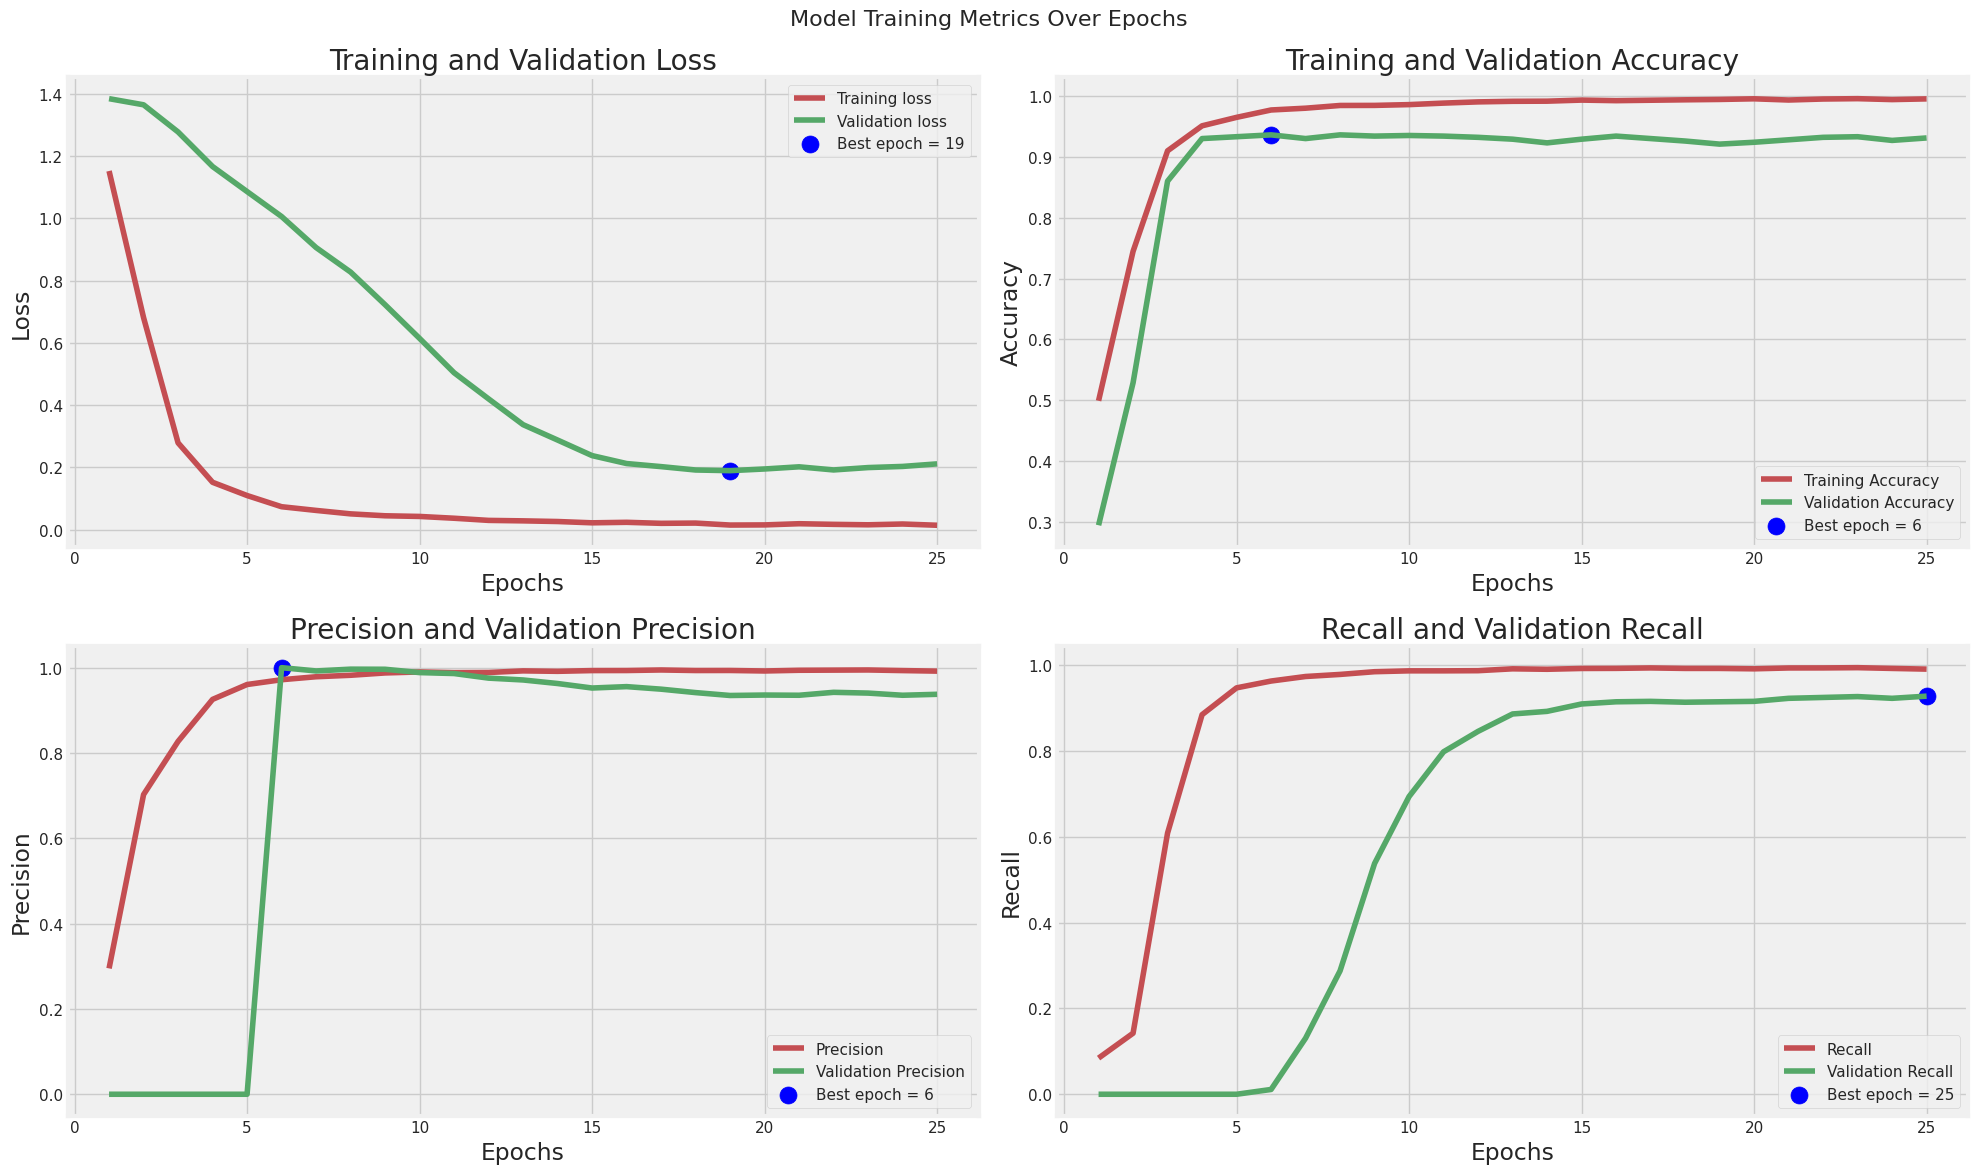

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


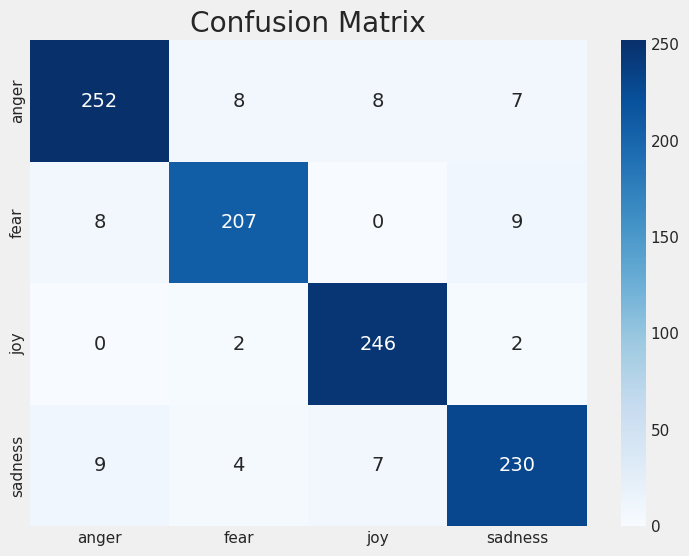

Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.92      0.93       275
        fear       0.94      0.92      0.93       224
         joy       0.94      0.98      0.96       250
     sadness       0.93      0.92      0.92       250

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999



In [56]:
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()

# Confusion matrix
y_true = np.argmax(ts_y, axis=1)
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)

plt.figure(figsize=(8, 6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=emotions))

# 5. Save model

In [57]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

# 6. Prediction function

Text: I am very happy to finish this project
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


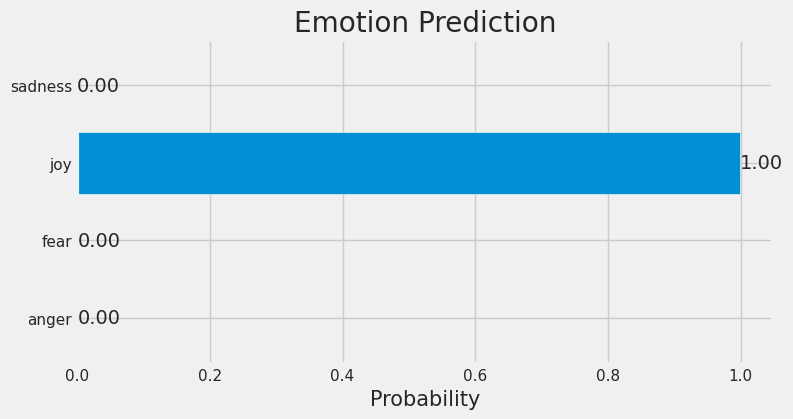

Text: I am very sad


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


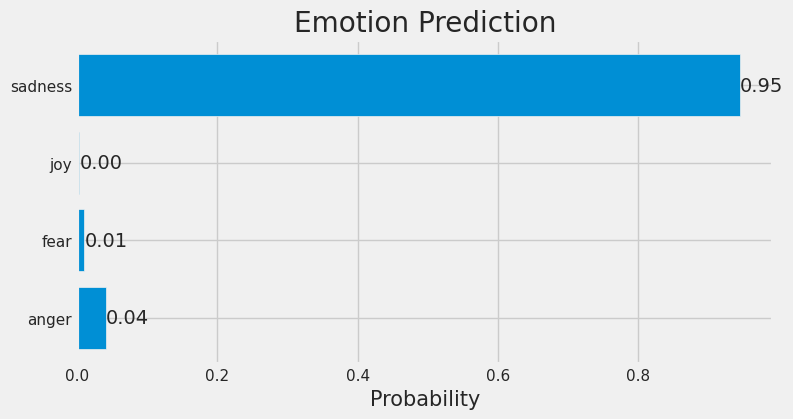

Text: Ahhhhhhhhhhhh, I wanna kill myself.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


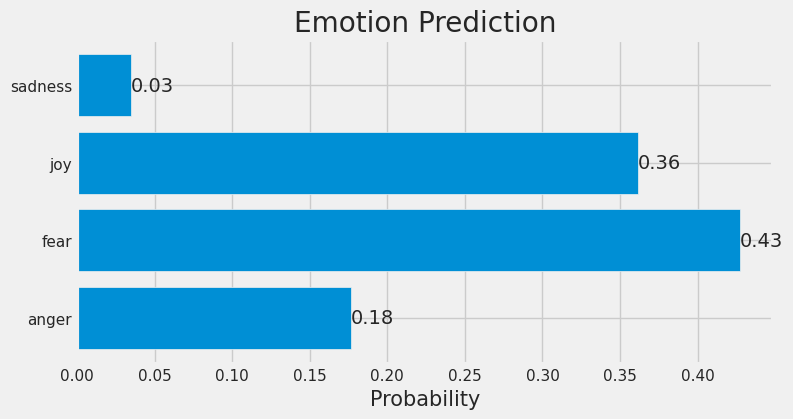

Text: I think, I am afraid.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


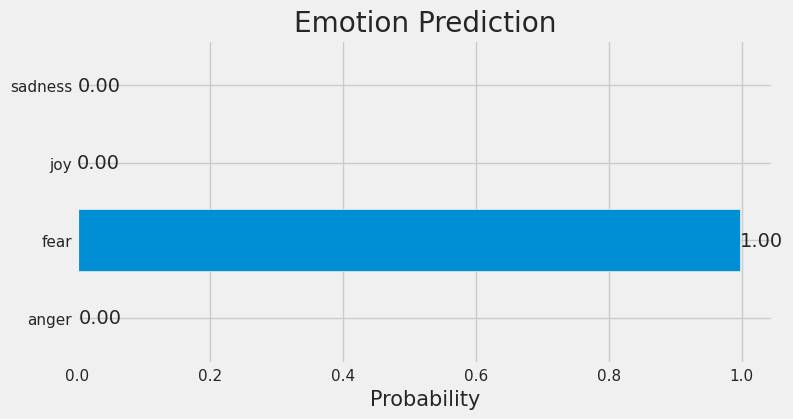

In [58]:
def predict(text, model_path='nlp.h5', token_path='tokenizer.pkl'):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import pickle
    from tensorflow.keras.models import load_model

    model = load_model(model_path)
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)

    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50, padding='post')
    predictions = model.predict([x_new, x_new])

    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'}
    label = list(emotions.values())
    probs = predictions[0]

    plt.figure(figsize=(8, 4))
    bars = plt.barh(label, probs)
    plt.xlabel('Probability', fontsize=15)
    plt.title('Emotion Prediction')
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.show()

# Test predictions
test_texts = [
    'I am very happy to finish this project',
    'I am very sad',
    'Ahhhhhhhhhhhh, I wanna kill myself.',
    'I think, I am afraid.'
]
for txt in test_texts:
    print(f"Text: {txt}")
    predict(txt)